# Import Dependencies

In [1]:
import rclpy
import cv2
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd

from sensor_msgs.msg import Image, PointCloud2
from geometry_msgs.msg import Pose
from rclpy.callback_groups import ReentrantCallbackGroup
from threading import Thread
import pymoveit2 
from pymoveit2 import MoveIt2, GripperInterface
import time

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import pyntcloud

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from py_cylinder_fitting import BestFitCylinder
from skspatial.objects import Points

import copy

%matplotlib widget


# Setup ROS Node To Capture Data 

In [2]:
rclpy.init()
node = rclpy.create_node("jupyter")
img_msg = None
depth = None
points = None

def depth_listener_callback(data):
    global depth
    depth = data

def points_listener_callback(data):
    global points
    points = data

def image_callback(data):
    global img_msg
    img_msg = data

subs = [node.create_subscription(
            Image,
            '/realsense/'+n,
            cb,
            10) for (n, cb) in [("image", image_callback),
                                ("depth_image", depth_listener_callback),
                                ]]


callback_group = ReentrantCallbackGroup()

moveit2 = MoveIt2(node=node, 
                  joint_names=['ur5_shoulder_pan_joint', 'ur5_shoulder_lift_joint',
                               'ur5_elbow_joint','ur5_wrist_1_joint',
                               'ur5_wrist_2_joint','ur5_wrist_3_joint'],
                  base_link_name='ur5_base_link',
                  end_effector_name='gripper',
                  group_name='arm',
                  callback_group=callback_group
                 )

  # Create gripper interface
gripper_interface = GripperInterface(
        node=node,
        gripper_joint_names=['finger_joint'],
        open_gripper_joint_positions=[0.0],
        closed_gripper_joint_positions=[0.07],
        gripper_group_name='gripper',
        callback_group=callback_group,
        gripper_command_action_name="gripper_controller/follow_joint_trajectory",
    )

# Spin the node in background thread(s) and wait a bit for initialization
executor = rclpy.executors.MultiThreadedExecutor(4)
executor.add_node(node)
executor_thread = Thread(target=executor.spin, daemon=True, args=())
executor_thread.start() # Using threads, our node will keep spinning while we code 

time.sleep(5) # Give it 5 seconds to setup and recieve the first message

# Extract an image from the Camera



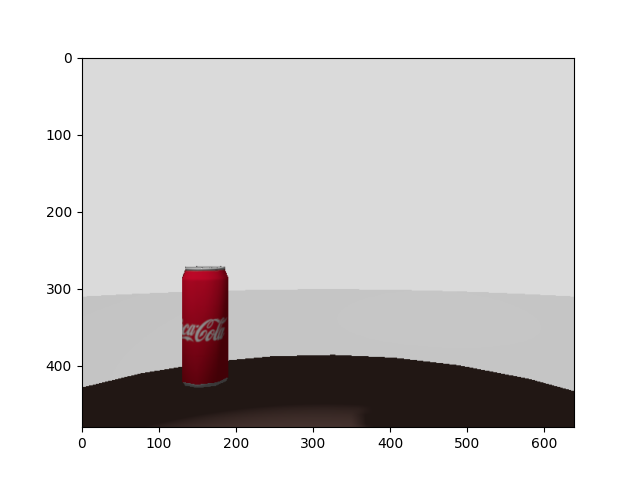

In [3]:

# Assuming msg contains the image data
height = img_msg.height
width = img_msg.width
channels = img_msg.step // width
img = np.frombuffer(img_msg.data, dtype=np.uint8).reshape(height, width, channels)

plt.imshow(img)

# Using Clip Seg to find location of can of coke in image

## Step 1: Clip Seg takes a 352x352 image, we need to resize our image 

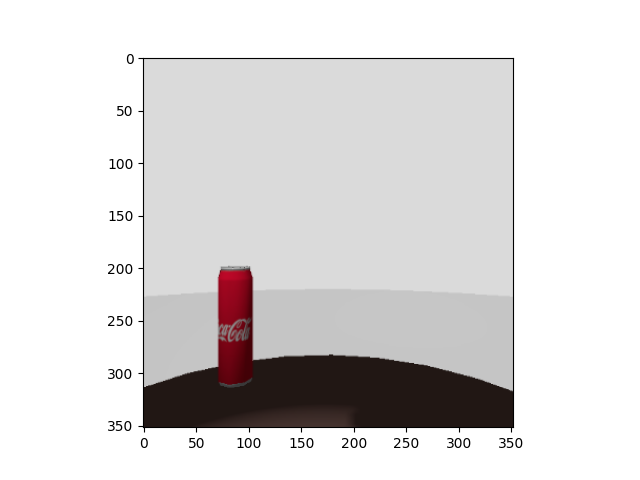

In [4]:
target_size = (352, 352)

res_img = cv2.resize(img, (352,352))

plt.imshow(res_img)
plt.show()

## Step 2: Pass the resized image into the clipseg model 

Using the transformers library 

/workspace/myenv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


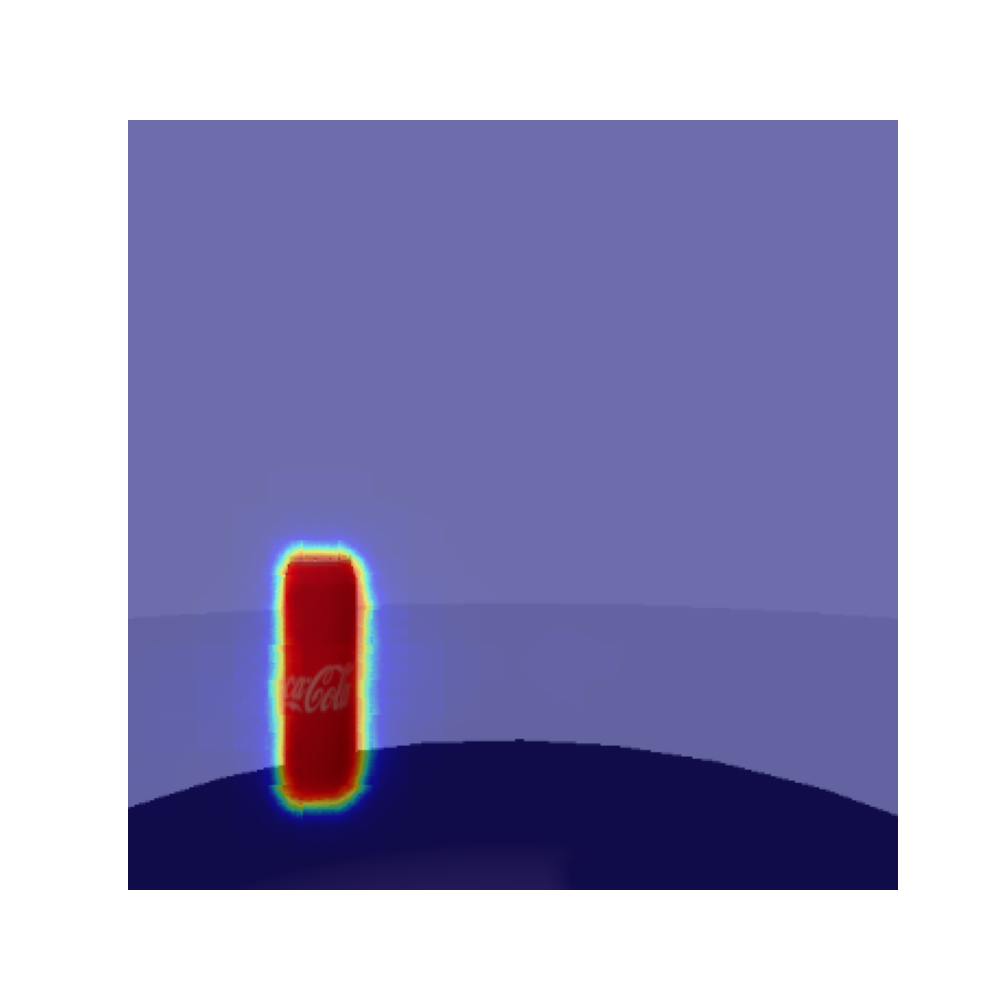

In [5]:

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

inputs = processor(text="a can of soda", images=res_img, return_tensors="pt")

outputs = model(**inputs)
mask = outputs.logits.sigmoid().detach().cpu().numpy()[0,:,:]

plt.figure(figsize=(10, 10))
plt.imshow(res_img)
plt.imshow(mask, alpha=0.5, cmap="jet")
plt.axis("off")
plt.show()

## Step 3: Resize the image back to its normal size 

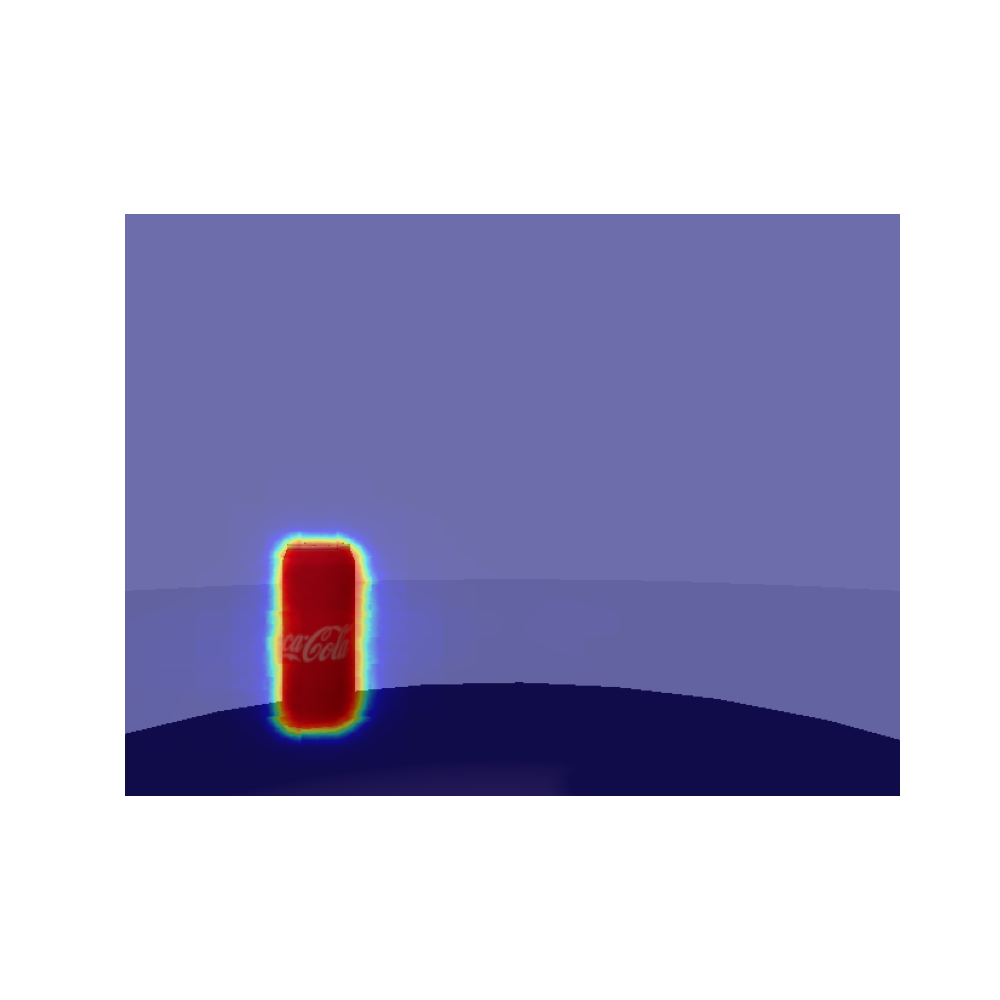

In [6]:
full_mask = cv2.resize(mask, (640,480))
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.imshow(full_mask, alpha=0.5, cmap="jet")
#plt.imshow(depth_image[:352,:352], alpha=0.5)
plt.axis("off")
plt.show()

## Step 4: Filter out everything that isn't high probability of being the target 


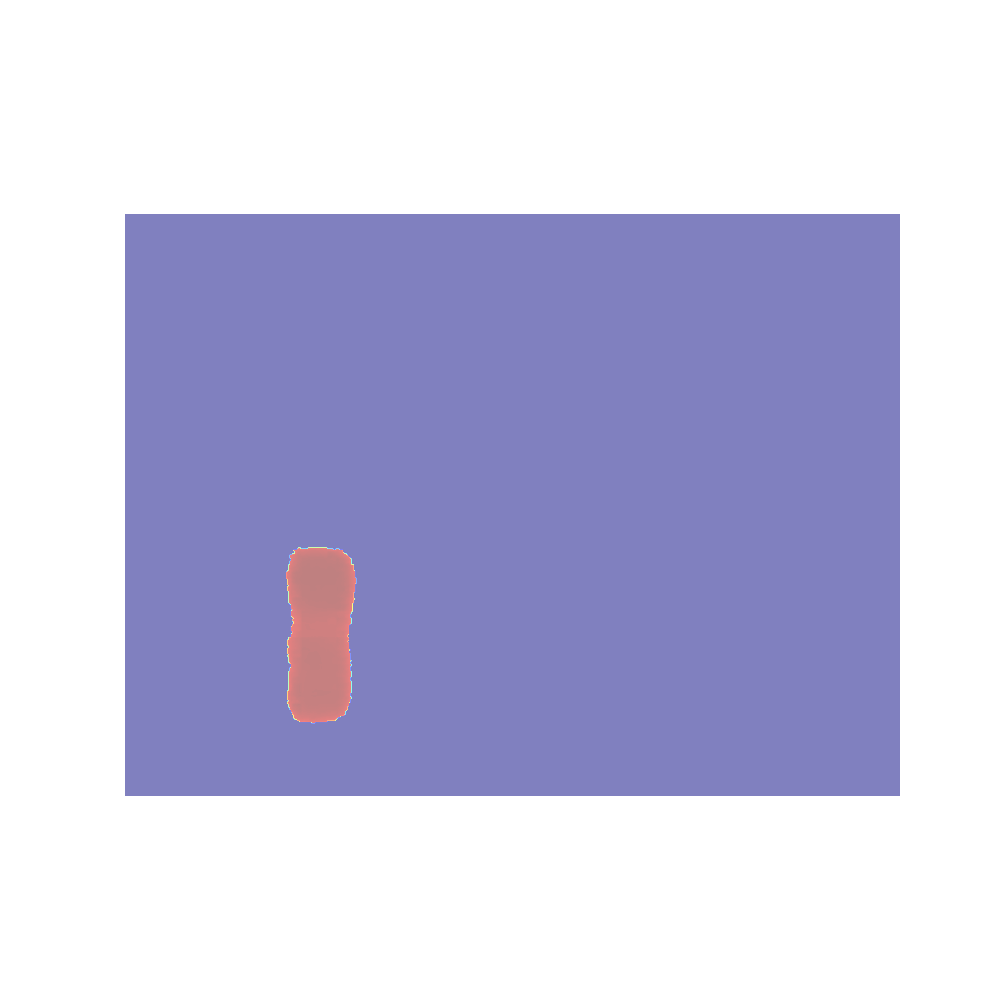

In [7]:
filtered_mask = full_mask.copy()
filtered_mask[full_mask < 0.9] =0

plt.figure(figsize=(10, 10))
#plt.imshow(img)
plt.imshow(filtered_mask, alpha=0.5, cmap="jet")
plt.axis("off")
plt.show()

# Next, lets convert the depth image into a point cloud

## Step 1: Extract the image and then use the known properties of the camera to get points 

In [8]:
depth_image = np.frombuffer(depth.data, dtype=np.float32).reshape(depth.height, depth.width)

def depth_to_point_cloud(depth_image, fx, fy, cx, cy):
    height, width = depth_image.shape
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    xx, yy = np.meshgrid(x, y)
    z = depth_image

    x = (xx - cx) * z / fx
    y = (yy - cy) * z / fy

    points = np.stack((x, y, z), axis=-1) #.reshape(-1, 3)
    return points

depth_points = depth_to_point_cloud(depth_image, fx=554.254, fy=554.25, cx=320.0, cy=240.0)


/tmp/ipykernel_24816/561996920.py:10: RuntimeWarning: invalid value encountered in multiply
  x = (xx - cx) * z / fx
/tmp/ipykernel_24816/561996920.py:11: RuntimeWarning: invalid value encountered in multiply
  y = (yy - cy) * z / fy


## Step 2: Remove any points that are infinite and then select only points that have a high probability of being part of the soda can

In [9]:
# Remove any infinite points from the filtered mask. 
filtered_mask[np.isfinite(depth_points).all(axis=2)==False] = 0

cylinder_points = depth_points[filtered_mask > 0.9]

finite_depth_points = cylinder_points


# Now Lets remove any outliers in the point cloud

We will do this by assuming that the main cluster has atleast 50% of the points within 10cm of it

Then randomly sample 1000 of the points

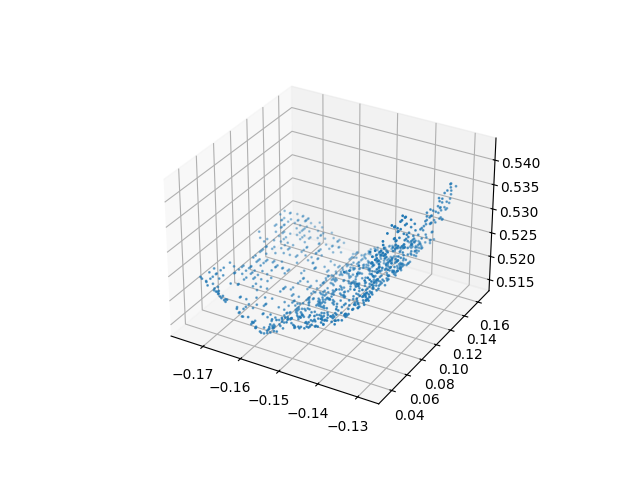

In [10]:
cloud = pyntcloud.PyntCloud(pd.DataFrame(finite_depth_points, columns=["x","y","z"]))

k = len(finite_depth_points)//2  # Number of nearest neighbors to use
kdtree = cloud.add_structure("kdtree")
filt = cloud.get_filter("ROR",k=k, r=0.1, kdtree_id=kdtree)
cloud.apply_filter(filt)

points_np = cloud.get_sample(name='points_random', n=1000).values

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], s=1)
plt.show()

# Fit a cylinder to the points

In [11]:

points = Points(points_np)
best_fit_cylinder = BestFitCylinder(points)

# Get the cylinder parameters
cylinder_center = best_fit_cylinder.point
cylinder_axis = best_fit_cylinder.vector
cylinder_radius = best_fit_cylinder.radius

print("Cylinder Center:", cylinder_center)
print("Cylinder Axis:", cylinder_axis)
print("Cylinder Radius:", cylinder_radius)

cylinder_height = (cylinder_axis[0]**2 + cylinder_axis[1]**2 + cylinder_axis[2]**2) ** 0.5

print("Cylinder height: ", cylinder_height)

Cylinder Center: [-0.15699207  0.16708133  0.54219034]
Cylinder Axis: [ 5.22280902e-05 -1.31255155e-01  7.44073196e-04]
Cylinder Radius: 0.026426445459825816
Cylinder height:  0.13125727440273066


# Get parameters of the cylnider, and change the axis so it is in the realsense_link coordinate frame 

In [12]:
cylinder_height = (cylinder_axis[0]**2 + cylinder_axis[1]**2 + cylinder_axis[2]**2) ** 0.5

# Define the pose of the cylinder
cylinder_pose = Pose()
cylinder_pose.position.x = cylinder_center[2]
cylinder_pose.position.y = -cylinder_center[0]
cylinder_pose.position.z = -cylinder_center[1]+cylinder_height/2
cylinder_pose.orientation.w = 1.0  # Assuming no rotation


# Now its time to use MoveIT to control the robot. 

## Step 1: Add the cylinder as an object to MoveIT planning scene 

In [13]:
moveit2.add_collision_cylinder('soda', height=cylinder_height, radius=cylinder_radius, pose=cylinder_pose, frame_id="realsense_link")

moveit2.planner_id = 'geometric::RRTConnect'

## Step 2: Create an approach pose, based off the location of the cylinder

Set it alittle offset in x and abit above in y.

Move to be just above the can. 

In [14]:
approach = copy.deepcopy(cylinder_pose)

approach.position.z+=0.4 # Alittle above
approach.position.x-=0.03 # Centering the approach in the gripper

approach.orientation.x=0.
approach.orientation.y=1.
approach.orientation.z=0.
approach.orientation.w=0.

In [15]:
moveit2.move_to_pose(pose=approach, target_link="ur5_tool0", frame_id="realsense_link")

[WARN] [1727412152.726075364] [jupyter]: Action 'execute_trajectory' was unsuccessful: 6.


In [16]:
res = moveit2.allow_collisions('soda', allow=True)

In [17]:
grasp_position = copy.deepcopy(cylinder_pose)

grasp_position.position.z+=0.1 # Alittle above
grasp_position.position.x-=0.03 # Centering the approach in the gripper

grasp_position.orientation.x=0.
grasp_position.orientation.y=1.
grasp_position.orientation.z=0.
grasp_position.orientation.w=0.

In [18]:
grasp_position

geometry_msgs.msg.Pose(position=geometry_msgs.msg.Point(x=0.5121903401620626, y=0.15699207473773086, z=-0.0014526893079546965), orientation=geometry_msgs.msg.Quaternion(x=0.0, y=1.0, z=0.0, w=0.0))

In [19]:
gripper_interface.open()

In [20]:
moveit2.move_to_pose(pose=grasp_position, target_link="ur5_tool0", frame_id="realsense_link")

In [21]:
gripper_interface.close()

In [22]:
moveit2.attach_collision_object('soda')

In [23]:
moveit2.move_to_pose(pose=approach, target_link="ur5_tool0", frame_id="realsense_link")